# Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cleaning_functions as cf
from unidecode import unidecode # source: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string 

In [2]:
# Source (via Wine.com) : https://www.kaggle.com/datasets/salohiddindev/wine-dataset-scraping-from-wine-com (prices in USD)
df_wine_com = pd.read_csv("../data/original_datasets/wine_com.csv", encoding='utf-16')

# Source (via Vivino.com): https://www.kaggle.com/datasets/budnyak/wine-rating-and-price (prices in EUR)
df_viv_1 = pd.read_csv('../data/original_datasets/vivino_one.csv')
df_viv_1.drop(columns=['Unnamed: 0'], inplace=True)

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_viv_2 = pd.read_csv('../data/original_datasets/vivino_two.csv')

# Source (via Vivino.com): https://www.kaggle.com/datasets/nikitatkachenko/vivinoredwine/data (prices in USD)
df_viv_3 = pd.read_csv('../data/original_datasets/validation_set.csv',encoding='latin1')
df_viv_3.dropna(inplace=True)
df_viv_3.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
# Make column names snake_case.
df_viv_1.columns = [col.lower().replace(' ', '_') for col in df_viv_1.columns]
df_viv_2.columns = [col.lower().replace(' ', '_') for col in df_viv_2.columns]
df_wine_com.columns = [col.lower().replace(' %', '').replace(' ', '_') for col in df_wine_com.columns]
df_viv_3.columns = [col.lower().replace(' ', '_') for col in df_viv_3.columns]

## Cleaning wine.com Dataset

In [4]:
df_wine_com.head()

,names,color_wine,prices,ml,ratings,ratingsnum,countrys,abv,rates
0,00 Wines VGW Chardonnay 2017,White Wine,79.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS"
1,00 Wines VGR Pinot Noir 2019,Red Wine,99.99$,750,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP"
2,00 Wines EGW Chardonnay 2019,White Wine,115.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE"
3,100 Nails Ranch Pinot Noir 2019,Red Wine,16.99$,750,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW
4,100 Nails Ranch Chardonnay 2019,White Wine,16.99$,750,0.0,0,"Chardonnay from Sonoma County, California",14.2,0


In [5]:
df_wine_com.shape

(15254, 9)

In [6]:
df_wine_com.drop_duplicates(inplace=True)

In [7]:
# Correct prices 
df_wine_com['prices'] = df_wine_com['prices'].str.replace(',', '').str.replace('$', '').astype(float)

In [8]:
# Extract column for vintage from name column
df_wine_com['vintage'] = df_wine_com['names'].apply(cf.get_vintage)
df_wine_com['vintage'].value_counts().head()

vintage
2019    3050
2020    2873
2018    2317
2021    1788
2017    1373
Name: count, dtype: int64

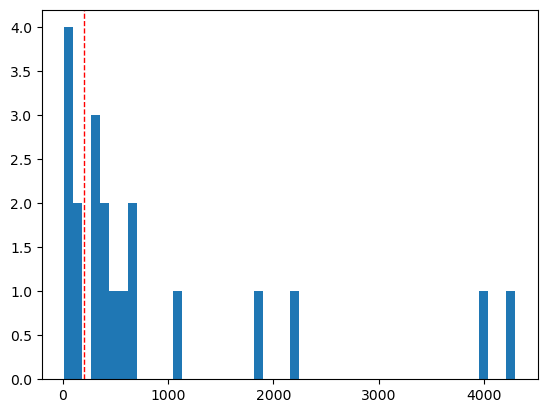

In [9]:
# Investigate very old wines
old_wines = df_wine_com[df_wine_com['vintage'] < '1985']
plt.hist(old_wines['prices'], bins=50)
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=1, label='$200');

In [10]:
'''
Remove vintage for wines below $200 in price and 'older' than 1985, having investgated them 
individually these are wines with the established year of the producer in their name 
not the year grape was picked.
'''
df_wine_com.loc[(df_wine_com['prices'] < 200) & (df_wine_com['vintage'] < '1985'), 'vintage'] = 'unknown'

In [11]:
# Keep only 750ml bottles.
df_wine_com = df_wine_com[df_wine_com['ml'] == 750].copy()
df_wine_com.drop(columns=['ml'], inplace=True)

In [12]:
df_wine_com['color_wine'] = df_wine_com['color_wine'].apply(cf.remove_accents)
df_wine_com['wine_variety'] = df_wine_com['color_wine'].apply(cf.get_wine_variety)
df_wine_com.drop(columns=['color_wine'], inplace=True)
# Remove 'other' wine varieties
df_wine_com = df_wine_com[df_wine_com['wine_variety'] != 'unknown'].copy()
df_wine_com['wine_variety'].value_counts()

wine_variety
red          8983
white        3687
sparkling     959
rose          413
other         257
Name: count, dtype: int64

In [13]:
# Rename columns 
df_wine_com.rename(columns = {'names' : 'name',
                            'prices' : 'price',
                            'ratings' : 'rating',
                            'ratingsnum': 'rating_qty', 
                            'rates' : 'reviewed_by'}, inplace = True)

In [14]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [15]:
df_wine_com['region'] = df_wine_com['countrys'].apply(cf.get_region)
# Drop 33 wines where region was not found 
df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()

In [16]:
# Extract country name from country column 
df_wine_com['country'] = df_wine_com['countrys'].apply(cf.get_country)
df_wine_com['country'].value_counts()

country
France          4128
California      2845
Italy           2381
unknown         1363
Spain            926
Australia        433
Argentina        407
Washington       300
Germany          258
Oregon           241
Portugal         219
Chile            219
New Zealand      202
Other U.S.       107
South Africa      99
Austria           74
Greece            62
Canada             2
Name: count, dtype: int64

In [17]:
# Investigate the unknown countries 
df_wine_com[df_wine_com['country'] == 'unknown']

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
6,1000 Stories Bourbon Barrel Aged Prospectors P...,19.99,0.0,0,Cabernet Sauvignon from California,0.0,WW,2020,red,California,unknown
7,1000 Stories American Barrel Aged Pinot Noir 2020,17.99,0.0,0,Pinot Noir from California,14.5,0,2020,red,California,unknown
8,1000 Stories Bourbon Barrel Aged Zinfandel 2020,18.99,3.8,11,Zinfandel from California,15.5,WW,2020,red,California,unknown
9,1000 Stories Bourbon Barrel Aged Chardonnay 2019,19.99,4.4,10,Chardonnay from California,14.4,TP,2019,white,California,unknown
10,1000 Stories Bourbon Barrel Aged Prospectors P...,18.99,0.0,0,Cabernet Sauvignon from California,14.9,0,2018,red,California,unknown
...,...,...,...,...,...,...,...,...,...,...,...
15210,Vinos Atlantico Vera Vinho Verde Rose 2021,12.99,0.0,0,Rosé from Portugal,11.5,0,2021,rose,Portugal,unknown
15212,Vinos De Arganza Marques De Montejos Mencia 2020,13.99,0.0,0,Mencia from Spain,13.0,"JS, WW",2020,red,Spain,unknown
15214,Vinos De Arganza Alvarez De Toledo Godello 2021,11.99,4.8,29,Godello from Spain,0.0,WW,2021,white,Spain,unknown
15215,Vinos De Arganza Palacio De Arganza Cabernet S...,13.99,4.8,30,Other Red Blends from Spain,13.0,"JS, WW",2020,red,Spain,unknown


In [18]:
df_wine_com.loc[df_wine_com['region'].isin(cf.us_states), 'country'] = 'United States'

In [19]:
# All unknown countries are cases where no region was available. The country was populated in the region or a US state. 
region_problems = df_wine_com[df_wine_com['country'] == 'unknown']
region_problems['region'].value_counts()

region
Israel               115
South Africa         105
Chile                 70
Portugal              70
Spain                 69
France                60
Italy                 55
Argentina             32
Austria               23
Uruguay               23
Greece                23
Australia             20
Lebanon               11
England               10
Slovenia               9
Germany                9
Hungary                8
Croatia                6
Brazil                 5
Armenia                3
New Zealand            3
China                  2
Other                  2
Macedonia (FYROM)      2
Other U.S.             1
Name: count, dtype: int64

In [20]:
# move those regions that are countries to the country column 
df_wine_com.loc[df_wine_com['country'] == 'unknown', 'country'] = df_wine_com.loc[df_wine_com['country'] == 'unknown', 'region']
# make those regions that are countries 'unknown'
df_wine_com.loc[df_wine_com['region'] == df_wine_com['country'], 'region'] = 'unknown'
# combine U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'Other U.S.', 'country'] = 'United States'
# combine all U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'California', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Washington', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Oregon', 'country'] = 'United States'
# rename macedonia 
df_wine_com.loc[df_wine_com['country'] == 'Macedonia (FYROM)', 'country'] = 'Macedonia'

In [21]:
df_wine_com['grape_variety'] = df_wine_com['countrys'].apply(cf.get_grape_1)

In [22]:
# EXTRACT PRODUCER NAMES 
# Step 1 - Match with producers from other datasets and custom list in cleaning_functions.py 
all_producers = list(df_viv_1['winery'].unique()) + list(df_viv_2['winery'].unique()) + list(df_viv_3['winery'].unique()) + cf.custom_producer_list
all_producers  = [cf.uniform_strings(word) for word in all_producers]
all_producers.remove('Domaine De La')
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [23]:
# 80% of producers matched by finding producer names from other datasets and custom list in cleaning_functions.py
# 2741 producers matched of total 14266
df_wine_com['producer_clean'] = df_wine_com['name'].apply(lambda x: cf.extract_string(x, all_producers))

In [24]:
# STEP 2 - Isolate part before grape names in column 'name' import list of grape varieties.
# This removes grape and year from X leaving X for review. X producers remain that have not be captured by first 2 steps. 
grape_list_long = pd.read_csv('../data/grape_varieties.csv')
grape_list_long.drop(columns = ['Unnamed: 0'], inplace = True)
varietal_set_long = set(grape_list_long['Variety'].dropna().apply(lambda x: cf.uniform_strings(x).strip().lower()))
df_wine_com['producer_varietal_removed'] = df_wine_com['name'].apply(lambda x : cf.remove_varietal(x, varietal_set_long))

In [25]:
df_wine_com.loc[df_wine_com['abv'] == 0, 'abv'] = np.nan

In [26]:
# 1431 producers remain that have not be captured by first 2 steps. 
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review') & (df_wine_com['producer_clean'] == 'review')].shape

(1431, 14)

In [27]:
df_wine_com['producer_dirty'] = df_wine_com['name'].apply(cf.get_dirty_producer)

In [28]:
shorterned_df = df_wine_com[(df_wine_com['producer_clean'] == 'review') &(df_wine_com['producer_varietal_removed'] == 'review')]

In [29]:
all_remaining_producers =  shorterned_df['producer_dirty'].value_counts().index
all_remaining_producers = all_remaining_producers.sort_values()

In [30]:
# No minimum number of ratings set for this scrape. 
df_wine_com['rating_qty'].describe()

count    14266.000000
mean        10.439577
std         49.378628
min          0.000000
25%          0.000000
50%          0.000000
75%          6.000000
max       1829.000000
Name: rating_qty, dtype: float64

In [31]:
df_wine_com['combined_methods_producer'] = df_wine_com.apply(cf.combine_methods, axis = 1)

In [32]:
df_wine_com['producer'] = df_wine_com['combined_methods_producer']

In [33]:
# Investgate wine of price 9999.99
df_wine_com[df_wine_com['price'] == 9999.99]
# This is a collectable highly prized wine producer Chateau Petrus, explaining the high price

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed,producer_dirty,combined_methods_producer,producer
3810,Chateau Petrus 2016,9999.99,4.7,11,"Bordeaux Red Blends from Pomerol, Bordeaux, Fr...",14.5,"JS, RP, D, JD, WE, WS",2016,red,Pomerol,France,Bordeaux Red Blends,Petrus,review,Chateau Petrus,Petrus,Petrus


In [34]:
# Add boolean column for source of data
df_wine_com['from_vivino'] = False
df_wine_com.drop(columns=['producer_clean', 'producer_varietal_removed',
                            'producer_dirty', 'combined_methods_producer','countrys' ], inplace=True)

# Cleaning Vivino 1 Dataset

In [35]:
df_viv_1.drop_duplicates(inplace=True)
print(df_viv_1.shape)
df_viv_1.head()

(34664, 9)


,name,country,region,winery,rating,numberofratings,price,year,category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,red


In [36]:
df_viv_1.rename(columns = {'winery' : 'producer', 
                           'numberofratings' : 'rating_qty', 
                           'category' : 'wine_variety',
                           'year' : 'vintage'
                           }, inplace = True)

In [37]:
# Remove accents from columns.
df_viv_1['name'] = df_viv_1['name'].apply(cf.uniform_strings)
df_viv_1['producer'] = df_viv_1['producer'].apply(cf.uniform_strings)
df_viv_1['region'] = df_viv_1['region'].apply(cf.uniform_strings)
df_viv_1['country'] = df_viv_1['country'].apply(cf.uniform_strings)

In [38]:
# Rename problem column
df_viv_1.loc[df_viv_1['producer'] == 'Domaine De La', 'producer'] = 'Domaine De La Rouge'

In [39]:
df_viv_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34664 entries, 0 to 34663
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          34664 non-null  object 
 1   country       34664 non-null  object 
 2   region        34664 non-null  object 
 3   producer      34664 non-null  object 
 4   rating        34664 non-null  float64
 5   rating_qty    34664 non-null  int64  
 6   price         34664 non-null  float64
 7   vintage       34664 non-null  object 
 8   wine_variety  34664 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.4+ MB


In [40]:
# Make name formatting structure the same as wine_com dataframe.
df_viv_1['name'] = df_viv_1['producer'] + ' ' + df_viv_1['name']

In [41]:
df_viv_1.loc[df_viv_1['vintage'] == 'N.V.', 'vintage'] = np.nan

In [42]:
# Minimum number of ratings 25 for this scrape. 
df_viv_1['rating_qty'].describe()

count    34664.000000
mean       415.287445
std        899.687438
min         25.000000
25%         66.000000
50%        157.000000
75%        401.000000
max      20293.000000
Name: rating_qty, dtype: float64

In [43]:
# Convert price to USD using https://www.xe.com/currencytables/ at date of scrape.
df_viv_1['price'] = round(df_viv_1['price'] * 1.0849853073421676, 2)
df_viv_1['price'].describe()

count    34664.000000
mean        42.471993
std         92.150517
min          3.850000
25%         11.590000
50%         19.750000
75%         41.400000
max       3700.660000
Name: price, dtype: float64

In [44]:
df_viv_1['abv'] = np.nan
df_viv_1['reviewed_by'] = 'unknown'
df_viv_1['from_vivino'] = True

In [45]:
# Get grape variety - iteratively added grape varieties to find those missed.
grape_varieties =(list(df_wine_com['grape_variety'].unique()) + ['red blend', 'shiraz', 'Pomerol', 'Lirac', 'Rosso di Toscana', 
                                                                 'Bardolino', 'Gigondas', 'Chianti', 'Monastrell', 'Sancerre Rouge',
                                                                 'Saint-Joseph', 'Fronsac','Roma Rosso','Garnacha','Barolo',
                                                                 'Côte-Rôtie','Madiran','Ruché','Tempranillo','Margaux', 'syrah', 
                                                                 'blend', 'Rioja', 'Super Tuscan', 'Chianti', 'pinot nero',
                                                                 'Carménère', 'Mencía', 'Mourvèdre', "Blaufränkisch", "Corvina",
                                                                 "Rondinella", "Molinara", "Sangiovese", 'baga', 
                                                                 "Corvina", "Rondinella", "Molinara", "Trincadeira",  "Prieto Picudo"])
grape_varieties = [cf.uniform_strings(i) for i in grape_varieties]


df_viv_1['grape_variety'] = df_viv_1['name'].apply(lambda x: cf.extract_varietal(x, grape_varieties))

# Cleaning Vivino 2 Dataset

In [46]:
df_viv_2.drop_duplicates(inplace=True)
print(df_viv_2.shape)
df_viv_2.head()

(2018, 9)


,winery,year,wine_id,wine,rating,num_review,price,country,region
0,Viña Oria,2019,1812139,Garnacha 2019,3.5,327,2.50,España,Cariñena
1,Ayuso,2017,2084964,Abadia del Roble Tinto 2017,2.9,52,2.54,España,La Mancha
2,Castillo de Liria,2020,1643745,Bobal - Shiraz 2020,3.4,85,2.56,España,Valencia
3,Castillo de Liria,2019,1643745,Bobal - Shiraz 2019,3.6,305,2.56,España,Valencia
4,Finca Venta de Don Quijote,2020,7166356,Tempranillo - Syrah 2020,3.6,129,2.72,España,Castilla


In [47]:
df_viv_2.rename(columns = {'winery' : 'producer', 
                           'num_review' : 'rating_qty', 
                           'year' : 'vintage',
                           'wine' : 'name'
                           }, inplace = True)

In [48]:
df_viv_2['name'] = df_viv_2['name'].apply(cf.uniform_strings)
df_viv_2['producer'] = df_viv_2['producer'].apply(cf.uniform_strings)
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)

In [49]:
df_viv_2['grape_variety'] = df_viv_2['name'].apply(cf.get_grape_2)

In [50]:
df_viv_2['name'] = df_viv_2['producer'] + ' ' + df_viv_2['name']
df_viv_2['name'] = df_viv_2['name'].str.replace('-', '')
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)
df_viv_2['country'] = 'Spain'
df_viv_2.loc[df_viv_2['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [51]:
# Minimum number of ratings 25 for this scrape. Same as df_viv_1.
df_viv_2['rating_qty'].describe()

count     2018.000000
mean       321.930624
std       1035.124164
min         25.000000
25%         49.000000
50%        104.000000
75%        260.750000
max      29389.000000
Name: rating_qty, dtype: float64

In [52]:
# Convert price to USD using https://www.xe.com/currencytables/ at date of scrape.
df_viv_2['price'] = round(df_viv_2['price'] * 1.1195970296830366, 2)
df_viv_2['price'].describe()

count    2018.000000
mean        9.711695
std         2.746843
min         2.800000
25%         7.670000
50%         9.915000
75%        11.980000
max        14.440000
Name: price, dtype: float64

In [53]:
df_viv_2['wine_variety'] = 'red'
df_viv_2['abv'] = np.nan
df_viv_2['reviewed_by'] = 'unknown'
df_viv_2['from_vivino'] = True
df_viv_2.drop(columns = 'wine_id', inplace=True)

# Cleaning Vivino 3 Dataset

In [54]:
df_viv_3.drop_duplicates(inplace=True)
df_viv_3.dropna(inplace = True)
print(df_viv_3.shape)
df_viv_3.head()

(10369, 8)


,wine_name,wine_year,wine_country,wine_region,winery,wine_rating,n_ratings,wine_price
0,Merlot,2019,United States,California,Crane Lake,3.6,30,4.99
1,Cabernet Sauvignon,2011,United States,Columbia Valley,Hogue,3.3,76,4.95
2,Hot To Trot Smooth Red Blend,2013,United States,Columbia Valley,14 Hands,3.7,3917,4.99
3,Cabernet Sauvignon,2010,Chile,Maule Valley,Aromo,3.0,189,4.99
4,Loggia del Conte Chianti,2016,Italy,Chianti,Le Chiantigiane,3.3,149,4.99


In [55]:
df_viv_3.rename(columns = {'wine_year' : 'vintage',
                         'wine_country' : 'country',
                         'n_ratings':'rating_qty',
                         'wine_region': 'region',
                         'winery':'producer',
                         'wine_rating':'rating',
                         'wine_price': 'price'
                         }, inplace = True)

In [56]:
df_viv_3['wine_variety'] = 'red'

In [57]:
df_viv_3['wine_name'] = df_viv_3['wine_name'].apply(cf.uniform_strings)
df_viv_3['country'] = df_viv_3['country'].apply(cf.uniform_strings)
df_viv_3['region'] = df_viv_3['region'].apply(cf.uniform_strings)
df_viv_3['producer'] = df_viv_3['producer'].apply(cf.uniform_strings)

In [58]:
# 70% of grape types accounted for, the rest are obscure types e.g. 'tinto' or 'red'. Likely blends of various grapes. 
df_viv_3['grape_variety'] = df_viv_3['wine_name'].apply(lambda x: cf.extract_varietal(x, grape_varieties))

In [59]:
df_viv_3['vintage'].unique()

array([2019, 2011, 2013, 2010, 2016, 2009, 2017, 2015, 2018, 2007, 2020,
       2000, 2006, 2008, 2014, 2012, 2005, 2003, 1999, 2021, 1994, 2004,
       1984, 2001])

In [60]:
df_viv_3['rating_qty'].describe()

count    10369.000000
mean       516.262513
std       1152.623501
min         25.000000
25%         68.000000
50%        164.000000
75%        462.000000
max      24713.000000
Name: rating_qty, dtype: float64

In [61]:
df_viv_3['name'] = df_viv_3['producer'] + ' ' + df_viv_3['wine_name'] + ' ' + df_viv_3['vintage'].astype(str)
df_viv_3['reviewed_by'] = 'unknown'
df_viv_3['abv'] = np.nan
df_viv_3['from_vivino'] = True
df_viv_3.drop(columns = ['wine_name'],   inplace=True)

# Combine Dataframes

In [62]:
desired_columns_order = ['name', 'region', 'country', 'vintage', 'producer', 'wine_variety','grape_variety',
                         'price', 'rating', 'rating_qty', 'abv', 'reviewed_by', 'from_vivino']
df_wine_com = df_wine_com[desired_columns_order]
df_viv_1 = df_viv_1[desired_columns_order]
df_viv_2 = df_viv_2[desired_columns_order]
df_viv_3 = df_viv_3[desired_columns_order]
print(df_wine_com.shape)
print(df_viv_1.shape)
print(df_viv_2.shape)
print(df_viv_3.shape)
df_combined = pd.concat([df_wine_com, df_viv_1, df_viv_2, df_viv_3])

(14266, 13)
(34664, 13)
(2018, 13)
(10369, 13)


In [63]:
df_combined['grape_variety'] = df_combined['grape_variety'].apply(cf.uniform_strings)

In [64]:
# # The below was revisited to iteratively to add new producer names to producer list in cleaning_functions.py
# # Print shortlist of producer names to check and iteratively add to customer producer list
# sorted_producer_list = np.sort(df_combined['producer'].unique())
# def get_first_two_words(text):
#     words = text.split()
#     return " ".join(words[:2]) if len(words) >= 2 else text

# producer_prefixes = {}

# # Populate a dictionary with producer that have the same first two words
# for producer in sorted_producer_list:
#     prefix = get_first_two_words(producer)
#     if prefix in producer_prefixes:
#         producer_prefixes[prefix].append(producer)
#     else:
#         producer_prefixes[prefix] = [producer]

# # Print producers with matching first two words to check for ungrouped producers
# for prefix, producers in producer_prefixes.items():
#     if len(producers) > 1:  # Check if more than one producer has the same prefix
#         print(f"Producers with matching first two words '{prefix}': {', '.join(producers)}")

In [65]:
# Combine producers found to be undergrouped. 
df_combined.loc[df_combined['producer'] == 'Tinto Negro Tintonegro', 'producer'] =  'Tinto Negro'
df_combined.loc[df_combined['producer'] == 'Stags Leap', 'producer'] =  'Stags Leap Wine Cellars'
df_combined.loc[df_combined['producer'] == 'St Supery Dollarhide', 'producer'] =  'St Supery'
df_combined.loc[df_combined['producer'] == 'Sans Liege', 'producer'] =  'Sans Liege Wines'
df_combined.loc[df_combined['producer'] == 'Round Pond', 'producer'] =  'Round Pond Estate'
df_combined.loc[df_combined['producer'] == 'Roscato Dolce Sweet', 'producer'] =  'Roscato Dolce'
df_combined.loc[df_combined['producer'] == 'Robert Mondavi Private Selectiona', 'producer'] =  'Robert Mondavi'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heredia Vina Tondonia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Vina Nia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Rioja White Vina Tondonia Gran', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Rioja Vina Tondonia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'Prayers Of Saints', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prayers Of Sinners', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prayers Of Sinners Saints', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prats Symington Ps', 'producer'] =  'Prats Symington'
df_combined.loc[df_combined['producer'] == 'Potek Winery Demetria', 'producer'] =  'Potek Winery'
df_combined.loc[df_combined['producer'] == 'Potek Winery Tierra Alta', 'producer'] =  'Potek Winery'
df_combined.loc[df_combined['producer'] == 'Pedro Parra', 'producer'] =  'Pedro Parra Y Familia'
df_combined.loc[df_combined['producer'] == 'Paul K Et Fils Classique', 'producer'] =  'Paul K Et Fils'
df_combined.loc[df_combined['producer'] == 'Miguel Torres Chile', 'producer'] =  'Miguel Torres Chile'
df_combined.loc[df_combined['producer'] == 'Michel Men Coteaux Bourguignons', 'producer'] =  'Michel Men'
df_combined.loc[df_combined['producer'] == 'Mark Ryan', 'producer'] =  'Mark Ryan Winery'
df_combined.loc[df_combined['producer'] == 'Louis Jadot Domaine Gagey', 'producer'] =  'Louis Jadot'
df_combined.loc[df_combined['producer'] == 'Joseph Swan', 'producer'] =  'Joseph Swan Vineyards'
df_combined.loc[df_combined['producer'] == 'Joseph Burrier Chateau De Beauregard', 'producer'] =  'Joseph Burrier'
df_combined.loc[df_combined['producer'] == 'J Lohr', 'producer'] =  'J Lohr Vineyards Wines'
df_combined.loc[df_combined['producer'] == 'Isa And Pierre Clement Menetousalon', 'producer'] =  'Isa And Pierre Clement'
df_combined.loc[df_combined['producer'] == 'Isa And Pierre Clement Menetou Salon', 'producer'] =  'Isa And Pierre Clement'
df_combined.loc[df_combined['producer'] == 'Hund Acre Few And Far Between', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hund Acre Precious', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hund Acre Wraith', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hamilton Russell', 'producer'] =  'Hamilton Russell Vineyards'
df_combined.loc[df_combined['producer'] == 'Golden West', 'producer'] =  'Golden West Vineyard'
df_combined.loc[df_combined['producer'] == 'Ghettina Franciacorta Milledi', 'producer'] =  'Ghettina Franciacorta'
df_combined.loc[df_combined['producer'] == 'Ghettina Franciacorta Cuvee', 'producer'] =  'Ghettina Franciacorta'
df_combined.loc[df_combined['producer'] == 'Francis Ford Coppola', 'producer'] =  "Francis Ford Coppola Winery"
df_combined.loc[df_combined['producer'] == 'Ermitage Du Pic', 'producer'] =  "Ermitage Du Pic Saint Loup"
df_combined.loc[df_combined['producer'] == 'Eden Rift', 'producer'] = 'Eden Rift Vineyards'
df_combined.loc[df_combined['producer'] == '4 Kilos Vinicola', 'producer'] = '4 Kilos'
df_combined.loc[df_combined['producer'] == '7 Deadly', 'producer'] = '7 Deadly Wines'
df_combined.loc[df_combined['producer'] == 'A To Z', 'producer'] = 'A To Z Wineworks'
df_combined.loc[df_combined['producer'] == 'Agricola De Borja', 'producer'] = 'Agricola De Borja Vina'
df_combined.loc[df_combined['producer'] == 'Albert Boxler Edelswicker', 'producer'] = 'Albert Boxler'
df_combined.loc[df_combined['producer'] == 'Alfo Bertolani Allantica', 'producer'] = 'Alfo Bertolani'
df_combined.loc[df_combined['producer'] == 'Alfo Bertolani Dolce Fiore', 'producer'] = 'Alfo Bertolani'
df_combined.loc[df_combined['producer'] == 'Anne Amie Vineyards', 'producer'] = 'Anne Amie'
df_combined.loc[df_combined['producer'] == 'Bedrock Wine Co', 'producer'] = 'Bedrock Wine'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Fincas De Ganuza Rioja', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Rioja', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza O', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Rioja Gran', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Chateau Bourgneuf Vieux Chateau Bourgneuf', 'producer'] = 'Chateau Bourgneuf'
df_combined.loc[df_combined['producer'] == 'Chateau Feuillet Valle Daosta', 'producer'] = 'Chateau Feuillet'
df_combined.loc[df_combined['producer'] == 'Chateau Fuisse Julienas', 'producer'] = 'Chateau Fuisse'
df_combined.loc[df_combined['producer'] == 'Clos Henri Vineyard', 'producer'] = 'Clos Henri'
df_combined.loc[df_combined['producer'] == 'Domaine Anne Gros Jeanpaul Tollot', 'producer'] = 'Domaine Anne'
df_combined.loc[df_combined['producer'] == 'Domaine Comte', 'producer'] = 'Domaine Comte Georges De Vogue'
df_combined.loc[df_combined['producer'] == 'Domaine Eugene Carrel Fils', 'producer'] = 'Domaine Eugene Carrel Et Fils'
df_combined.loc[df_combined['producer'] == 'Domaine Joseph', 'producer'] = 'Domaine Joseph Roty'
df_combined.loc[df_combined['producer'] == 'Dry Creek', 'producer'] = 'Dry Creek Vineyard'

In [66]:
grape_value_counts = df_combined['grape_variety'].value_counts()
not_grapes = grape_value_counts[grape_value_counts < 5]
df_combined['grape_variety'] = df_combined['grape_variety'].apply(lambda x: 'Unknown' if x in not_grapes.index else x)
len(df_combined['grape_variety'].unique())

156

In [67]:
# Remove 'other' wine varietys (port, sherry and other fortified wines etc.) from dataset. 
# Leaving only red, white, rose and sparkling. 
df_combined = df_combined[df_combined['wine_variety'] != 'other'].copy()
df_viv_3 = df_viv_3[df_viv_3['wine_variety'] != 'other'].copy()
df_combined.loc[df_combined['vintage'] == 'unknown', 'vintage'] = np.nan
df_combined.dropna(subset=['vintage'], inplace=True)

In [68]:
df_combined.to_csv('../data/clean_combined_wines.csv', index=False)
df_combined.to_csv('../app/clean_combined_wines_copy.csv', index=False)